In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display, display_markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import subprocess as sp
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import arviz as az
import bambi
import copy
import random
import logging

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 300

from subs2vec.utensils import log_timer
from subs2vec.vecs import Vectors
from subs2vec.neighbors import compute_nn

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

def norm(x):
    return x / np.linalg.norm(x, 2)

sns.set(style='whitegrid')
pd.options.mode.chained_assignment = None

# Loading and preparing data

In [2]:
df_joint = pd.read_csv('data/data_plus_predictors.tsv', sep='\t', low_memory=False)
display(df_joint)

,index,group,dimension,pp_id,color,rating,experiment,self_vs_other,art,fiction,...,sighted,group_eff,group_z,original,replication_1,replication_2,other,self,self_vs_other_eff,self_vs_other_z
0,0,sighted,cold-hot,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
1,1,sighted,ripe-unripe,sighted_1,white,7,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
2,2,sighted,new-old,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
3,3,sighted,submissive-aggressive,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
4,4,sighted,selfless-jealous,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42975,28507,sighted,light-heavy,sighted_68129,red,5,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42976,28508,sighted,relaxed-tense,sighted_68129,red,5,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42977,28509,sighted,alive-dead,sighted_68129,red,6,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42978,28510,sighted,fast-slow,sighted_68129,red,3,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199


# Intraclass correlations

In [3]:
# create item-level variable
df_joint['item'] = df_joint.apply(lambda x: x['color'] + '_' + x['dimension'], axis=1)

## Blind group intraclass correlation

In [4]:
pg.intraclass_corr(df_joint[df_joint['group'] == 'blind'],
                   targets='item', raters='pp_id', ratings='rating').round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.35,7.47,152,1683,0.0,"[0.29, 0.42]"
1,ICC2,Single random raters,0.35,8.16,152,1672,0.0,"[0.29, 0.42]"
2,ICC3,Single fixed raters,0.37,8.16,152,1672,0.0,"[0.32, 0.44]"
3,ICC1k,Average raters absolute,0.87,7.47,152,1683,0.0,"[0.83, 0.9]"
4,ICC2k,Average random raters,0.87,8.16,152,1672,0.0,"[0.83, 0.9]"
5,ICC3k,Average fixed raters,0.88,8.16,152,1672,0.0,"[0.85, 0.9]"


## Sighted group intraclass correlation

In [6]:
pg.intraclass_corr(df_joint[(df_joint['dimension'] != 'high-low')
                            & (df_joint['experiment'] != 'replication_1')
                            & (df_joint['group'] == 'sighted')
                            & (df_joint['self_vs_other'] == 'self')],
                   targets='item', raters='pp_id', ratings='rating').round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.30,48.13,152,16371,0.0,"[0.26, 0.36]"
1,ICC2,Single random raters,0.30,49.89,152,16264,0.0,"[0.26, 0.36]"
2,ICC3,Single fixed raters,0.31,49.89,152,16264,0.0,"[0.27, 0.37]"
3,ICC1k,Average raters absolute,0.98,48.13,152,16371,0.0,"[0.97, 0.98]"
4,ICC2k,Average random raters,0.98,49.89,152,16264,0.0,"[0.97, 0.98]"
5,ICC3k,Average fixed raters,0.98,49.89,152,16264,0.0,"[0.98, 0.98]"


The sighted group does not include the all of the replication data, excluding about 30 participants because the data for those participants were unbalanced and this ICC algorithm does not play nice with unbalanced data. No matter though, there are about 100 participants in the 2nd round of the replication, which together with the original data is more than enough for estimating the ICC.

Overall, it appears that:
1. ICC between participants was slightly higher the blind group (.35) than in the sighted group (.30), but it's close enough that we can't really make any strong inferences about between-group differences.
2. ICC to the mean was lower in the blind group than in the sighted group, but since we know that means are more stable in larger groups, it follows that we cannot directly compare this measure acrss groups of different sample sizes.

To address the second point, we can repeatedly draw a smaller sample from the complete sighted dataset to see if this yields ICCs more similar to the ICCs for the blind participants.

In [7]:
df_sighted = df_joint[
    (df_joint['dimension'] != 'high-low')
    & (df_joint['experiment'] != 'replication_1')
    & (df_joint['group'] == 'sighted')
    & (df_joint['self_vs_other'] == 'self')
]

# draw random samples from the replication dataset
iccs = []
for i in range(100):
    random_pps = random.sample(list(df_sighted['pp_id']), 12)
    iccs.append(
        pg.intraclass_corr(
            df_sighted[df_sighted['pp_id'].isin(random_pps)],
            targets='item', raters='pp_id', ratings='rating'
        ).round(2)
    )
pd.concat(iccs).groupby(['Type', 'Description']).mean().reset_index().sort_values('Description',
                                                                                  ascending=False).round(2)

,Type,Description,ICC,F,df1,df2,pval
0,ICC1,Single raters absolute,0.29,5.70,152.0,1597.32,0.0
2,ICC2,Single random raters,0.29,5.91,152.0,1586.88,0.0
4,ICC3,Single fixed raters,0.30,5.91,152.0,1586.88,0.0
1,ICC1k,Average raters absolute,0.81,5.70,152.0,1597.32,0.0
3,ICC2k,Average random raters,0.82,5.91,152.0,1586.88,0.0
5,ICC3k,Average fixed raters,0.82,5.91,152.0,1586.88,0.0


If we draw a random sample from the replication data with the same number of participants as the blind participants in the original data, we get ICC-to-means that are more similar to the blind group. This means that a) the variability in the blind group doesn't seem to be out of the ordinary, and b) given the need to resort to subsampling, ICC-to-mean is perhaps not the ideal tool for examining differences between these groups.

## ICC in low versus high reading groups
One last thing we can check is whether participants that read a lot are more similar to each other (more semantically aligned) than participants that do not read very much.

In [8]:
df_rep = df_joint[df_joint['experiment'] == 'replication_2']
df_rep['art_high'] = df_rep['art'] >= df_rep['art'].median()
df_rep['reading_motivation_high'] = df_rep['reading_motivation'] >= df_rep['reading_motivation'].median()

### Median split based on ART

In [15]:
# low ART group
pg.intraclass_corr(
    df_rep[df_rep['art_high'] == False],
    targets='item', raters='pp_id', ratings='rating'
).round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.29,19.35,161,6966,0.0,"[0.25, 0.35]"
1,ICC2,Single random raters,0.29,20.27,161,6923,0.0,"[0.25, 0.35]"
2,ICC3,Single fixed raters,0.30,20.27,161,6923,0.0,"[0.26, 0.36]"
3,ICC1k,Average raters absolute,0.95,19.35,161,6966,0.0,"[0.94, 0.96]"
4,ICC2k,Average random raters,0.95,20.27,161,6923,0.0,"[0.94, 0.96]"
5,ICC3k,Average fixed raters,0.95,20.27,161,6923,0.0,"[0.94, 0.96]"


In [16]:
# high ART group
pg.intraclass_corr(
    df_rep[df_rep['art_high'] == True],
    targets='item', raters='pp_id', ratings='rating'
).round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.37,26.52,161,6966,0.0,"[0.32, 0.42]"
1,ICC2,Single random raters,0.37,27.60,161,6923,0.0,"[0.32, 0.43]"
2,ICC3,Single fixed raters,0.38,27.60,161,6923,0.0,"[0.33, 0.43]"
3,ICC1k,Average raters absolute,0.96,26.52,161,6966,0.0,"[0.95, 0.97]"
4,ICC2k,Average random raters,0.96,27.60,161,6923,0.0,"[0.95, 0.97]"
5,ICC3k,Average fixed raters,0.96,27.60,161,6923,0.0,"[0.96, 0.97]"


## Median split based on reading motivation score

In [17]:
# low reading group
display(pg.intraclass_corr(
    df_rep[df_rep['reading_motivation_high'] == False],
    targets='item', raters='pp_id', ratings='rating'
).round(2))

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.35,24.93,161,7128,0.0,"[0.3, 0.4]"
1,ICC2,Single random raters,0.35,25.86,161,7084,0.0,"[0.3, 0.4]"
2,ICC3,Single fixed raters,0.36,25.86,161,7084,0.0,"[0.31, 0.41]"
3,ICC1k,Average raters absolute,0.96,24.93,161,7128,0.0,"[0.95, 0.97]"
4,ICC2k,Average random raters,0.96,25.86,161,7084,0.0,"[0.95, 0.97]"
5,ICC3k,Average fixed raters,0.96,25.86,161,7084,0.0,"[0.95, 0.97]"


In [18]:
# high reading group
pg.intraclass_corr(
    df_rep[df_rep['reading_motivation_high'] == True],
    targets='item', raters='pp_id', ratings='rating'
).round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.31,19.92,161,6804,0.0,"[0.26, 0.36]"
1,ICC2,Single random raters,0.31,20.92,161,6762,0.0,"[0.26, 0.36]"
2,ICC3,Single fixed raters,0.32,20.92,161,6762,0.0,"[0.27, 0.37]"
3,ICC1k,Average raters absolute,0.95,19.92,161,6804,0.0,"[0.94, 0.96]"
4,ICC2k,Average random raters,0.95,20.92,161,6762,0.0,"[0.94, 0.96]"
5,ICC3k,Average fixed raters,0.95,20.92,161,6762,0.0,"[0.94, 0.96]"


Overall, the differences between the groups are quite small, so we should be careful not to overinterpret them. On top of that, the direction of the differences is not the same for our two reading measures (ART and composite reading score) so there really doesn't seem to be anything here.

# Interaction between reading and predictiveness of COCA-fiction semantic projections
In addition to asking whether reading more makes participants more similar to each other, we can also ask whether reading more makes participants more similar to a semantic projection model based on word embeddings.  
We look at interactions between the COCA-fiction cosine measure, and various reading-related measures gathered from the participants in our replication study.

In [13]:
display(df_joint[df_joint['experiment'] == 'replication_2'].dropna())

,index,group,dimension,pp_id,color,rating,experiment,self_vs_other,art,fiction,...,group_eff,group_z,original,replication_1,replication_2,other,self,self_vs_other_eff,self_vs_other_z,item
14468,0,sighted,cold-hot,sighted_69212,brown,4,replication_2,self,3.0,0.0,...,1.0,0.211241,0,0,1,0,1,-1.0,-0.891882,brown_cold-hot
14469,1,sighted,ripe-unripe,sighted_69212,brown,7,replication_2,self,3.0,0.0,...,1.0,0.211241,0,0,1,0,1,-1.0,-0.891882,brown_ripe-unripe
14470,2,sighted,new-old,sighted_69212,brown,6,replication_2,self,3.0,0.0,...,1.0,0.211241,0,0,1,0,1,-1.0,-0.891882,brown_new-old
14471,3,sighted,submissive-aggressive,sighted_69212,brown,2,replication_2,self,3.0,0.0,...,1.0,0.211241,0,0,1,0,1,-1.0,-0.891882,brown_submissive-aggressive
14472,4,sighted,selfless-jealous,sighted_69212,brown,5,replication_2,self,3.0,0.0,...,1.0,0.211241,0,0,1,0,1,-1.0,-0.891882,brown_selfless-jealous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42975,28507,sighted,light-heavy,sighted_68129,red,5,replication_2,other,11.0,0.0,...,1.0,0.211241,0,0,1,1,0,1.0,1.121199,red_light-heavy
42976,28508,sighted,relaxed-tense,sighted_68129,red,5,replication_2,other,11.0,0.0,...,1.0,0.211241,0,0,1,1,0,1.0,1.121199,red_relaxed-tense
42977,28509,sighted,alive-dead,sighted_68129,red,6,replication_2,other,11.0,0.0,...,1.0,0.211241,0,0,1,1,0,1.0,1.121199,red_alive-dead
42978,28510,sighted,fast-slow,sighted_68129,red,3,replication_2,other,11.0,0.0,...,1.0,0.211241,0,0,1,1,0,1.0,1.121199,red_fast-slow


In [14]:
m_all = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*art_z'
    + ' + cosine_fic_z*fiction_z'
    + ' + cosine_fic_z*nonfiction_z'
    + ' + cosine_fic_z*reading_motivation_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*art_z + cosine_fic_z*fiction_z + cosine_fic_z*nonfiction_z + cosine_fic_z*reading_motivation_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_all = m_all.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 46,094
[INFO] Finished [100%]: Average Loss = 46,094
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, art_z, cosine_fic_z:art_z, fiction_z, cosine_fic_z:fiction_z, nonfiction_z, cosine_fic_z:nonfiction_z, reading_motivation_z, cosine_fic_z:reading_motivation_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, art_z|pp_id_sigma, art_z|pp_id_offset, cosine_fic_z:art_z|pp_id_sigma, cosine_fic_z:art_z|pp_id_offset, fiction_z|pp_id_sigma, fiction_z|pp_id_offset, cosine_fic_z:fiction_z|pp_id_sigma, cosine_fic_z:fiction_z|pp_id_offset, nonfiction_z|pp_id_sigma, nonfiction_z|pp_id_offset, cosine_fic_z:nonfiction_z|pp_id_sigma, cosine_fic_z:nonfiction_z|pp_id_offset, reading_motivation_z|pp_id_sigma, reading

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2962 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2962 seconds.


In [15]:
varnames = [
    'cosine_fic_z',
    'art_z',
    'fiction_z',
    'nonfiction_z',
    'reading_motivation_z',
    'cosine_fic_z:art_z',
    'cosine_fic_z:fiction_z',
    'cosine_fic_z:nonfiction_z',
    'cosine_fic_z:reading_motivation_z',
]
trace_df = az.summary(r_all, hdi_prob=.95, var_names=varnames).reset_index()
display(trace_df)

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,cosine_fic_z,0.354,0.014,0.325,0.380,0.0,0.0,6222.0,3268.0,1.0
1,art_z,0.033,0.020,-0.005,0.073,0.0,0.0,3638.0,3053.0,1.0
2,fiction_z,-0.033,0.025,-0.076,0.021,0.0,0.0,2928.0,2559.0,1.0
3,nonfiction_z,-0.003,0.022,-0.047,0.039,0.0,0.0,3592.0,3165.0,1.0
4,reading_motivation_z,-0.005,0.022,-0.048,0.037,0.0,0.0,3152.0,2860.0,1.0
5,cosine_fic_z:art_z,0.021,0.013,-0.004,0.046,0.0,0.0,4634.0,2323.0,1.0
6,cosine_fic_z:fiction_z,0.007,0.014,-0.021,0.033,0.0,0.0,5222.0,3428.0,1.0
7,cosine_fic_z:nonfiction_z,0.008,0.014,-0.018,0.034,0.0,0.0,4599.0,3331.0,1.0
8,cosine_fic_z:reading_motivation_z,-0.009,0.012,-0.032,0.015,0.0,0.0,5486.0,3217.0,1.0


/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


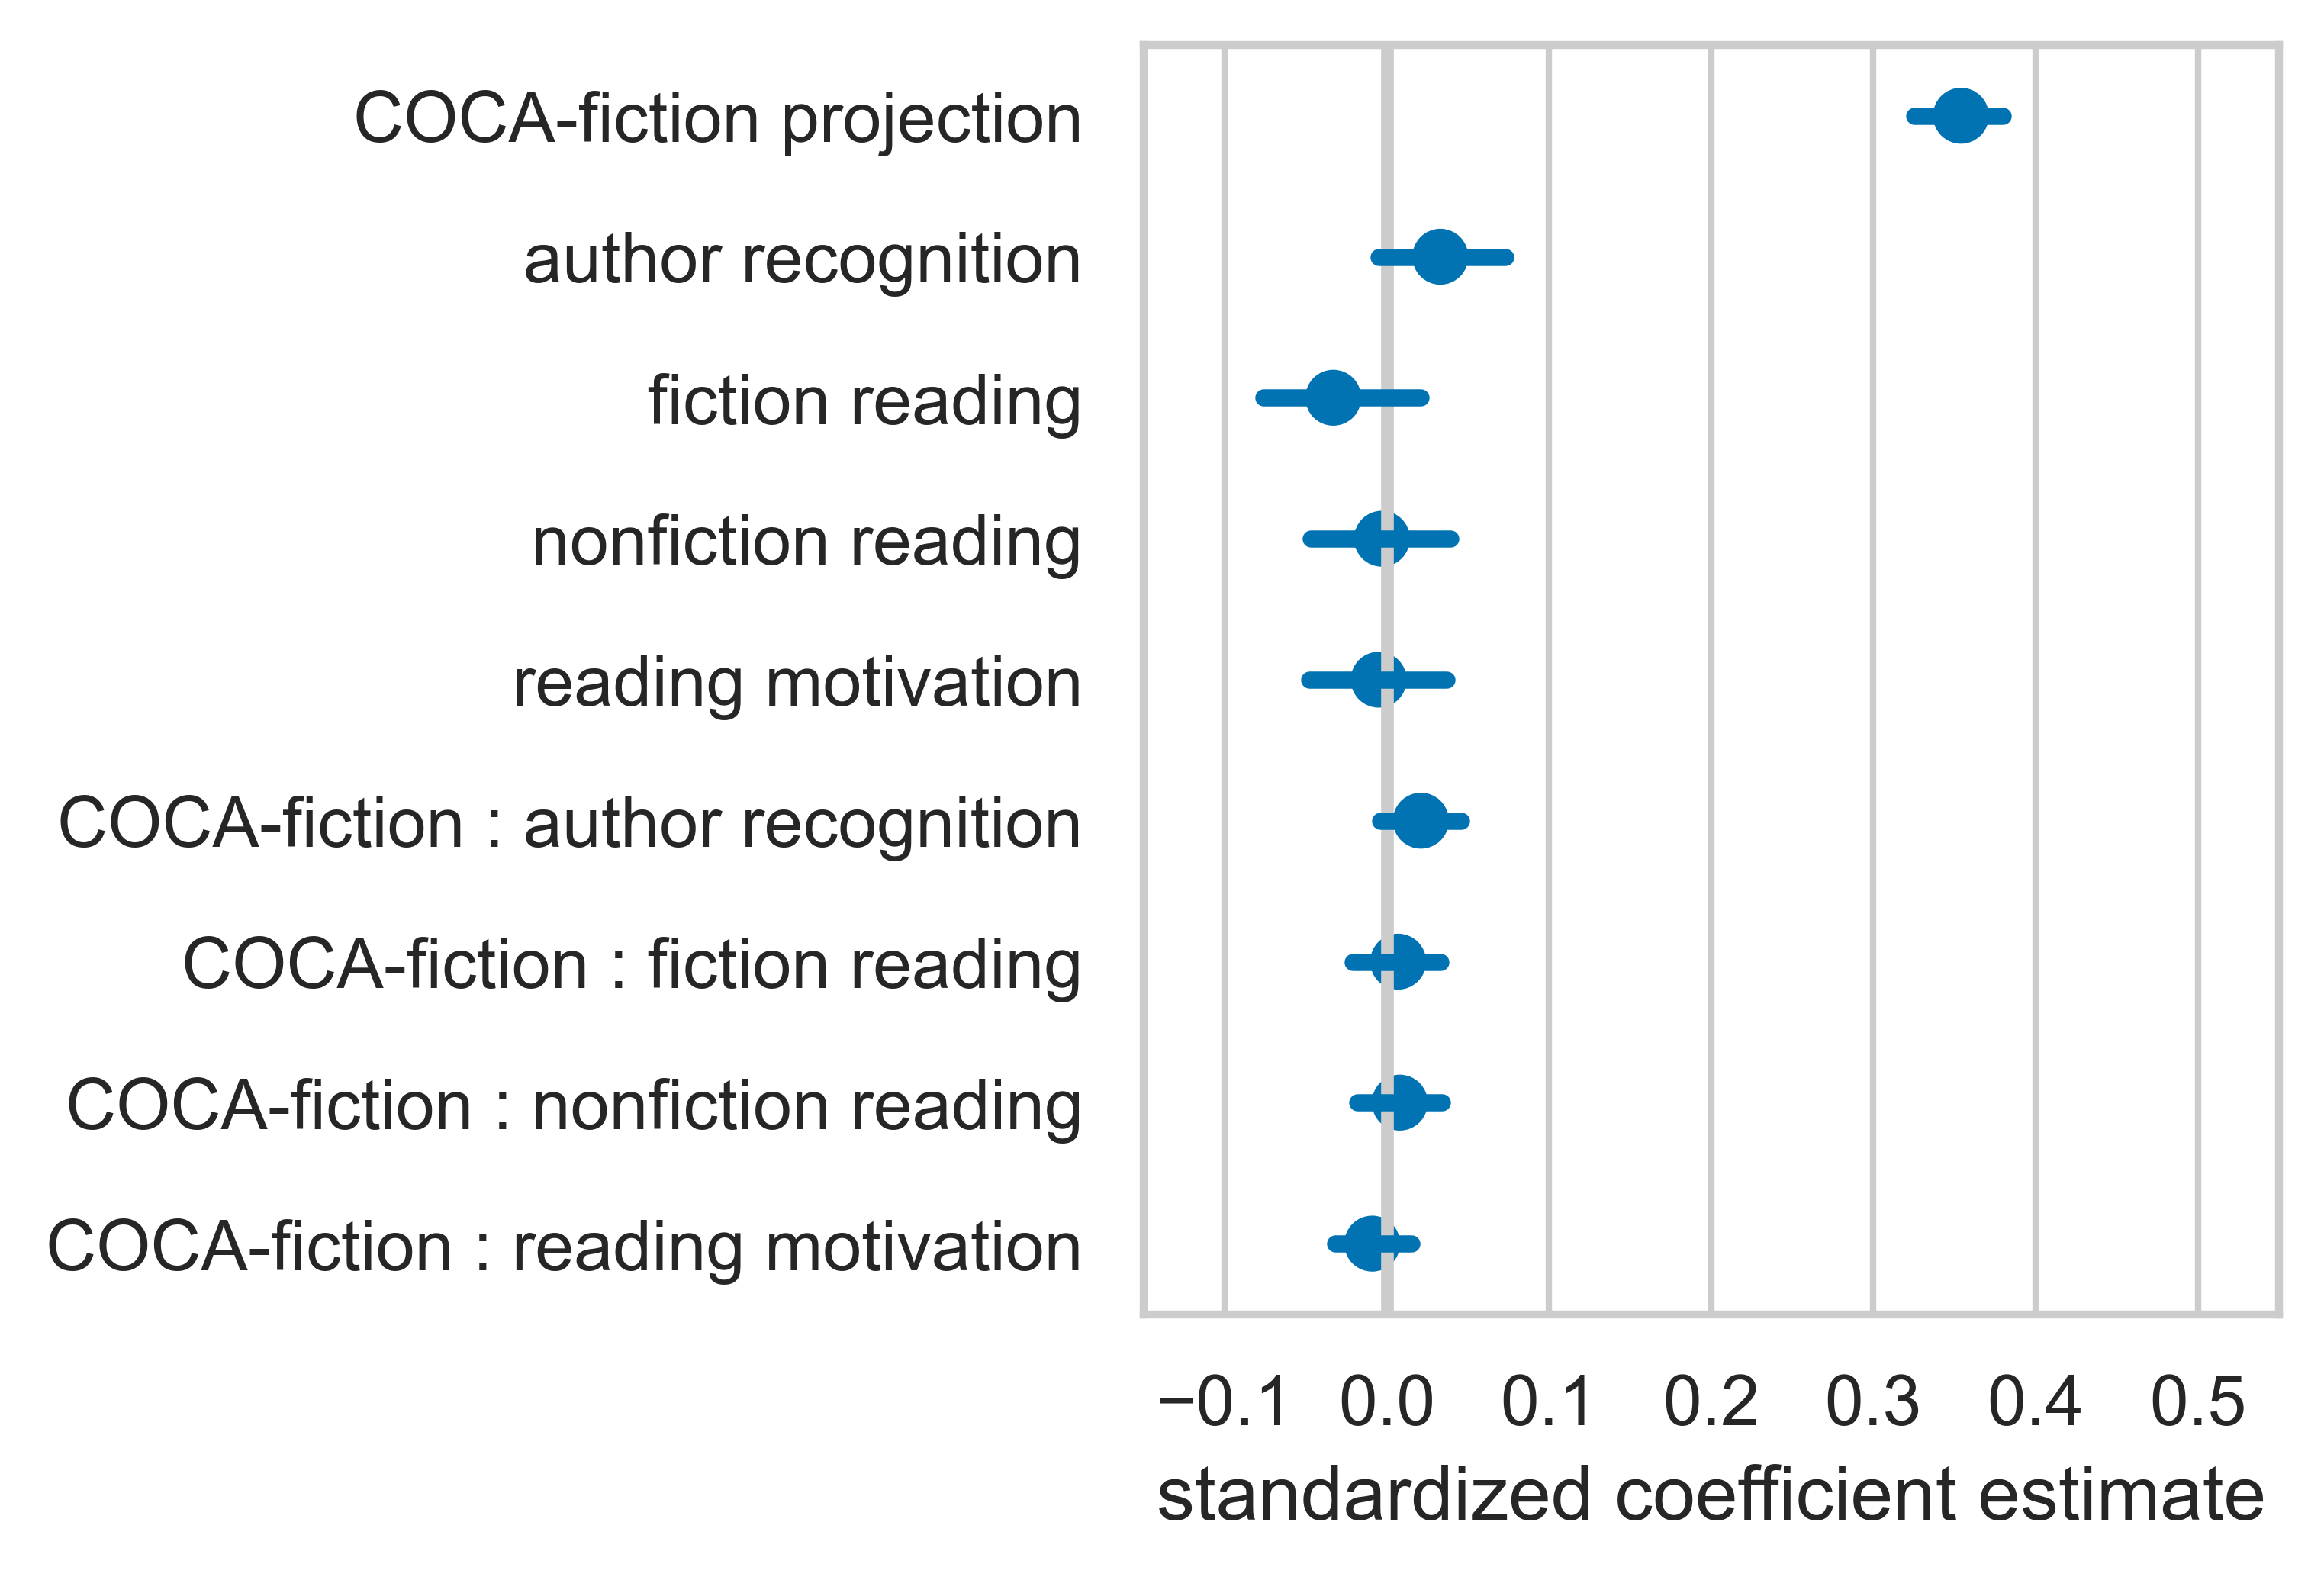

In [16]:
sns.set(palette='colorblind', style='whitegrid')
g, ax = plt.subplots(figsize=[3.2, 3.6])
ax.axvline(0, color='.8', linewidth=2)
sns.pointplot(data=trace_df, x='mean', y='index', join=False, ax=ax,
              color=sns.color_palette()[0])
hdi_df = trace_df.melt(id_vars=['index'], value_vars=['hdi_2.5%', 'hdi_97.5%'])
sns.pointplot(data=hdi_df, markers='', x='value', color=sns.color_palette()[0],
              y='index', ax=ax, join=False)
ax.set(xlim=[-.15, .55], ylabel='', xlabel='standardized coefficient estimate', xticks=[-.1, 0, .1, .2, .3, .4, .5],
       #title='95% CIs for reading measures\nand interactions with projections',
       title=''
)
ax.set(yticklabels=[
    'COCA-fiction projection',
    'author recognition',
    'fiction reading',
    'nonfiction reading',
    'reading motivation',
    'COCA-fiction : author recognition',
    'COCA-fiction : fiction reading',
    'COCA-fiction : nonfiction reading',
    'COCA-fiction : reading motivation'
])
plt.savefig('figures/reading_measures_forest.pdf', bbox_inches='tight')

In [17]:
display(az.summary(r_all, var_names=varnames, hdi_prob=.95))

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cosine_fic_z,0.354,0.014,0.325,0.380,0.0,0.0,6222.0,3268.0,1.0
art_z,0.033,0.020,-0.005,0.073,0.0,0.0,3638.0,3053.0,1.0
fiction_z,-0.033,0.025,-0.076,0.021,0.0,0.0,2928.0,2559.0,1.0
nonfiction_z,-0.003,0.022,-0.047,0.039,0.0,0.0,3592.0,3165.0,1.0
reading_motivation_z,-0.005,0.022,-0.048,0.037,0.0,0.0,3152.0,2860.0,1.0
cosine_fic_z:art_z,0.021,0.013,-0.004,0.046,0.0,0.0,4634.0,2323.0,1.0
cosine_fic_z:fiction_z,0.007,0.014,-0.021,0.033,0.0,0.0,5222.0,3428.0,1.0
cosine_fic_z:nonfiction_z,0.008,0.014,-0.018,0.034,0.0,0.0,4599.0,3331.0,1.0
cosine_fic_z:reading_motivation_z,-0.009,0.012,-0.032,0.015,0.0,0.0,5486.0,3217.0,1.0


## Reading subscales
### Reading motivation

In [18]:
m_comp = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_motivation_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_motivation_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_comp = m_comp.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 41,035
[INFO] Finished [100%]: Average Loss = 41,035
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_motivation_z, cosine_fic_z:reading_motivation_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_motivation_z|pp_id_sigma, reading_motivation_z|pp_id_offset, cosine_fic_z:reading_motivation_z|pp_id_sigma, cosine_fic_z:reading_motivation_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|color_sigma, 1|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_motivation_z, cosine_fic_z:reading_motivation_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequenc

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1470 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1470 seconds.


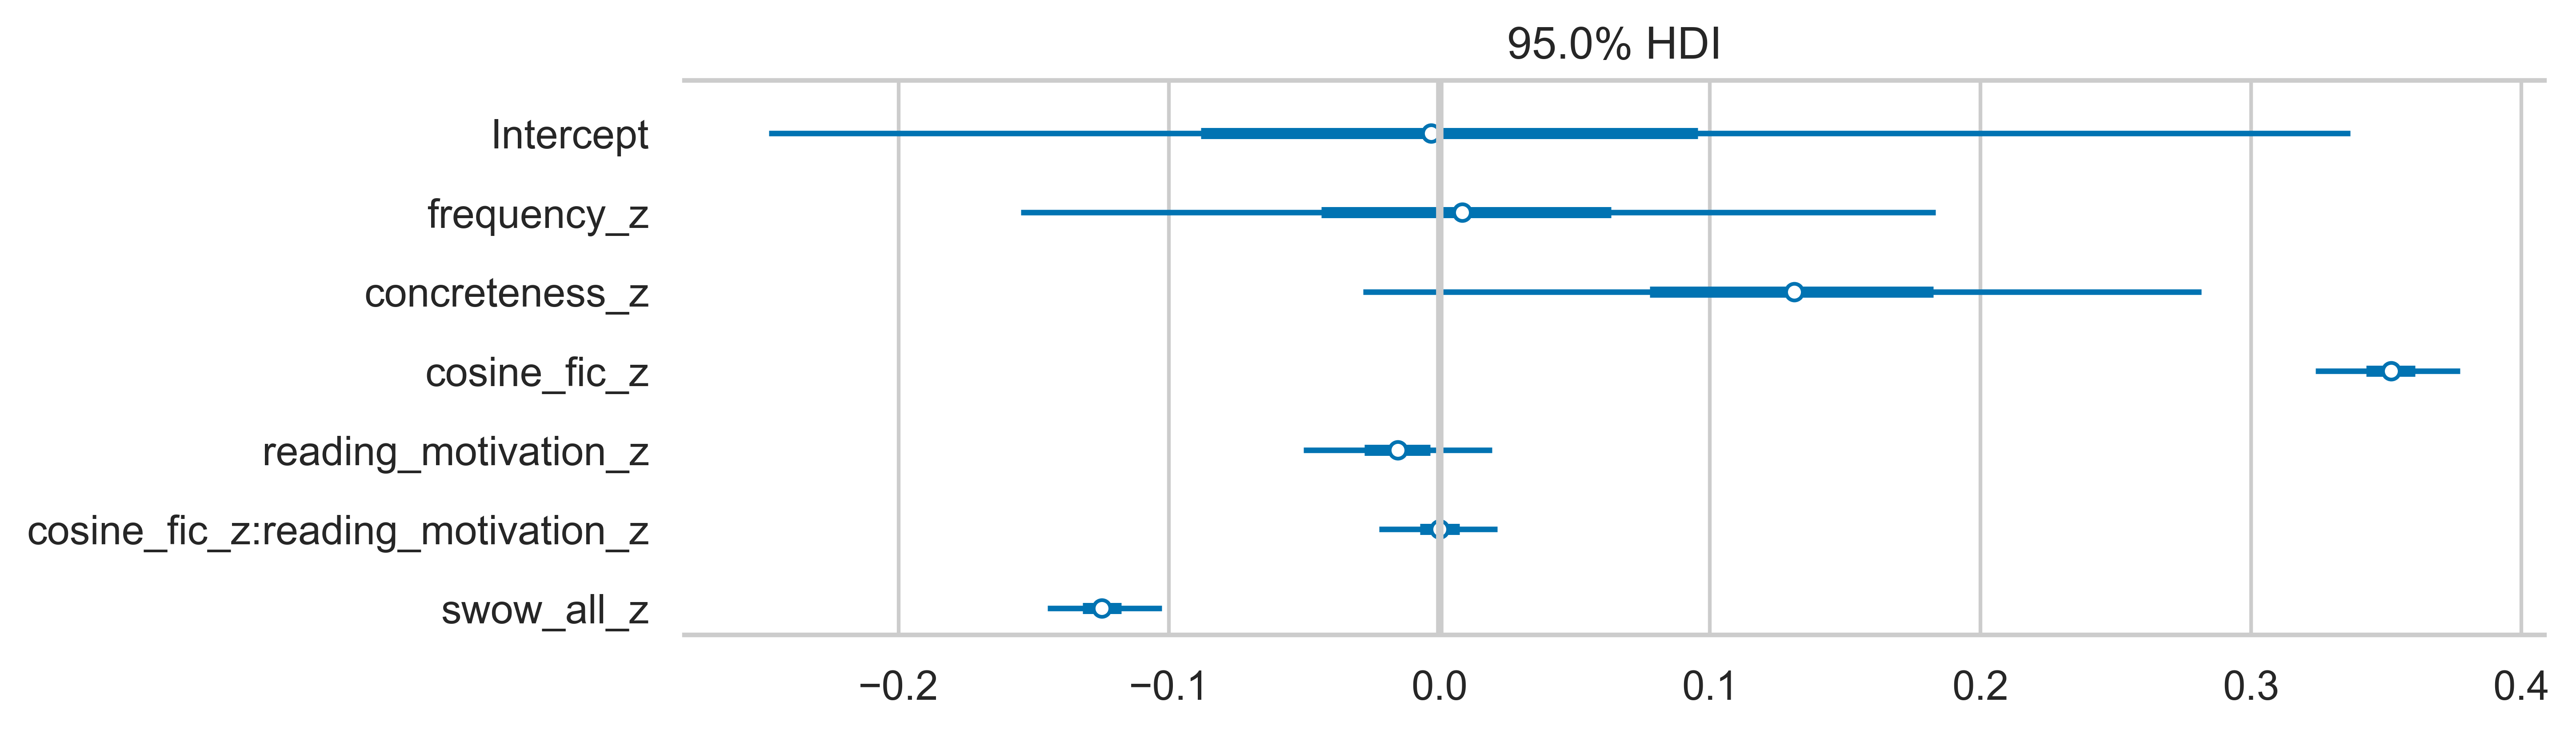

In [19]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_motivation_z',
    'cosine_fic_z:reading_motivation_z',
    'swow_all_z',
]
g = az.plot_forest(r_comp, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

### Reading as part of self

In [20]:
m_self = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_part_of_self_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_part_of_self_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_self = m_self.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 40,897
[INFO] Finished [100%]: Average Loss = 40,897
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_part_of_self_z, cosine_fic_z:reading_part_of_self_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_part_of_self_z|pp_id_sigma, reading_part_of_self_z|pp_id_offset, cosine_fic_z:reading_part_of_self_z|pp_id_sigma, cosine_fic_z:reading_part_of_self_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|color_sigma, 1|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_part_of_self_z, cosine_fic_z:reading_part_of_self_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1418 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1418 seconds.


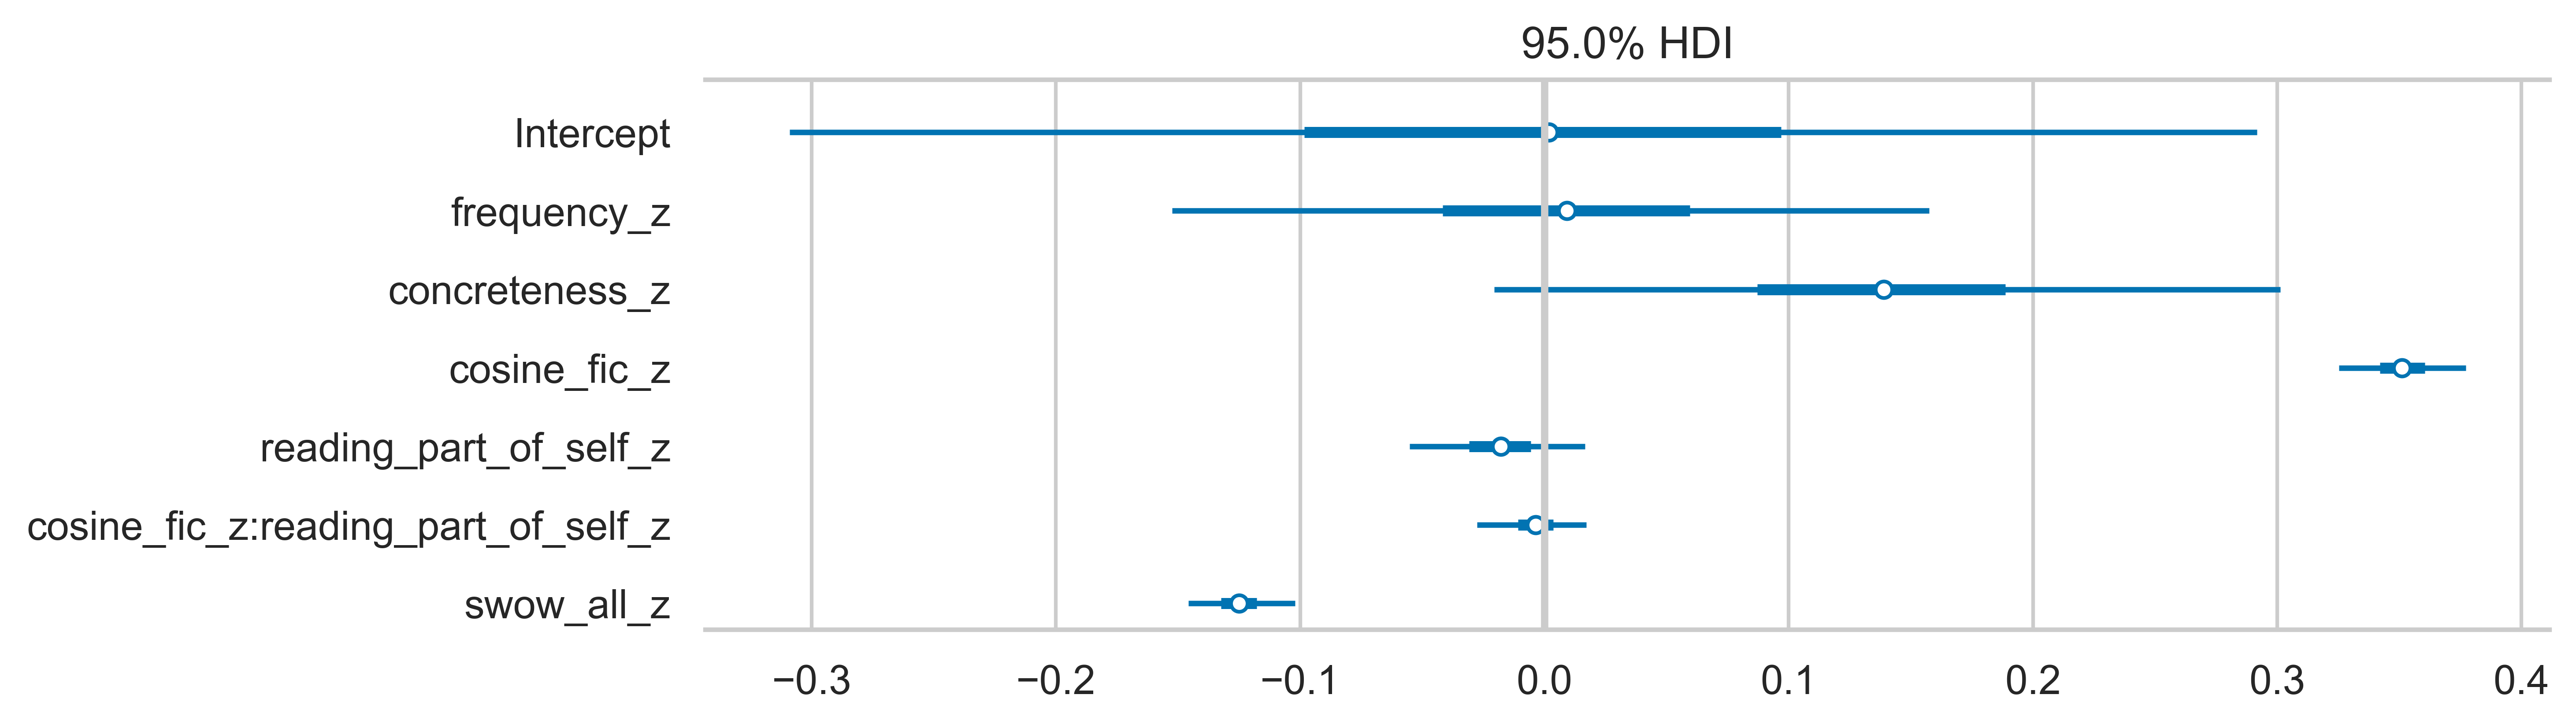

In [21]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_part_of_self_z',
    'cosine_fic_z:reading_part_of_self_z',
    'swow_all_z',
]
g = az.plot_forest(r_self, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

### Reading efficacy

In [22]:
m_eff = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_efficacy_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_efficacy_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_eff = m_eff.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 41,050
[INFO] Finished [100%]: Average Loss = 41,050
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_efficacy_z, cosine_fic_z:reading_efficacy_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_efficacy_z|pp_id_sigma, reading_efficacy_z|pp_id_offset, cosine_fic_z:reading_efficacy_z|pp_id_sigma, cosine_fic_z:reading_efficacy_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|color_sigma, 1|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_efficacy_z, cosine_fic_z:reading_efficacy_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1645 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1645 seconds.


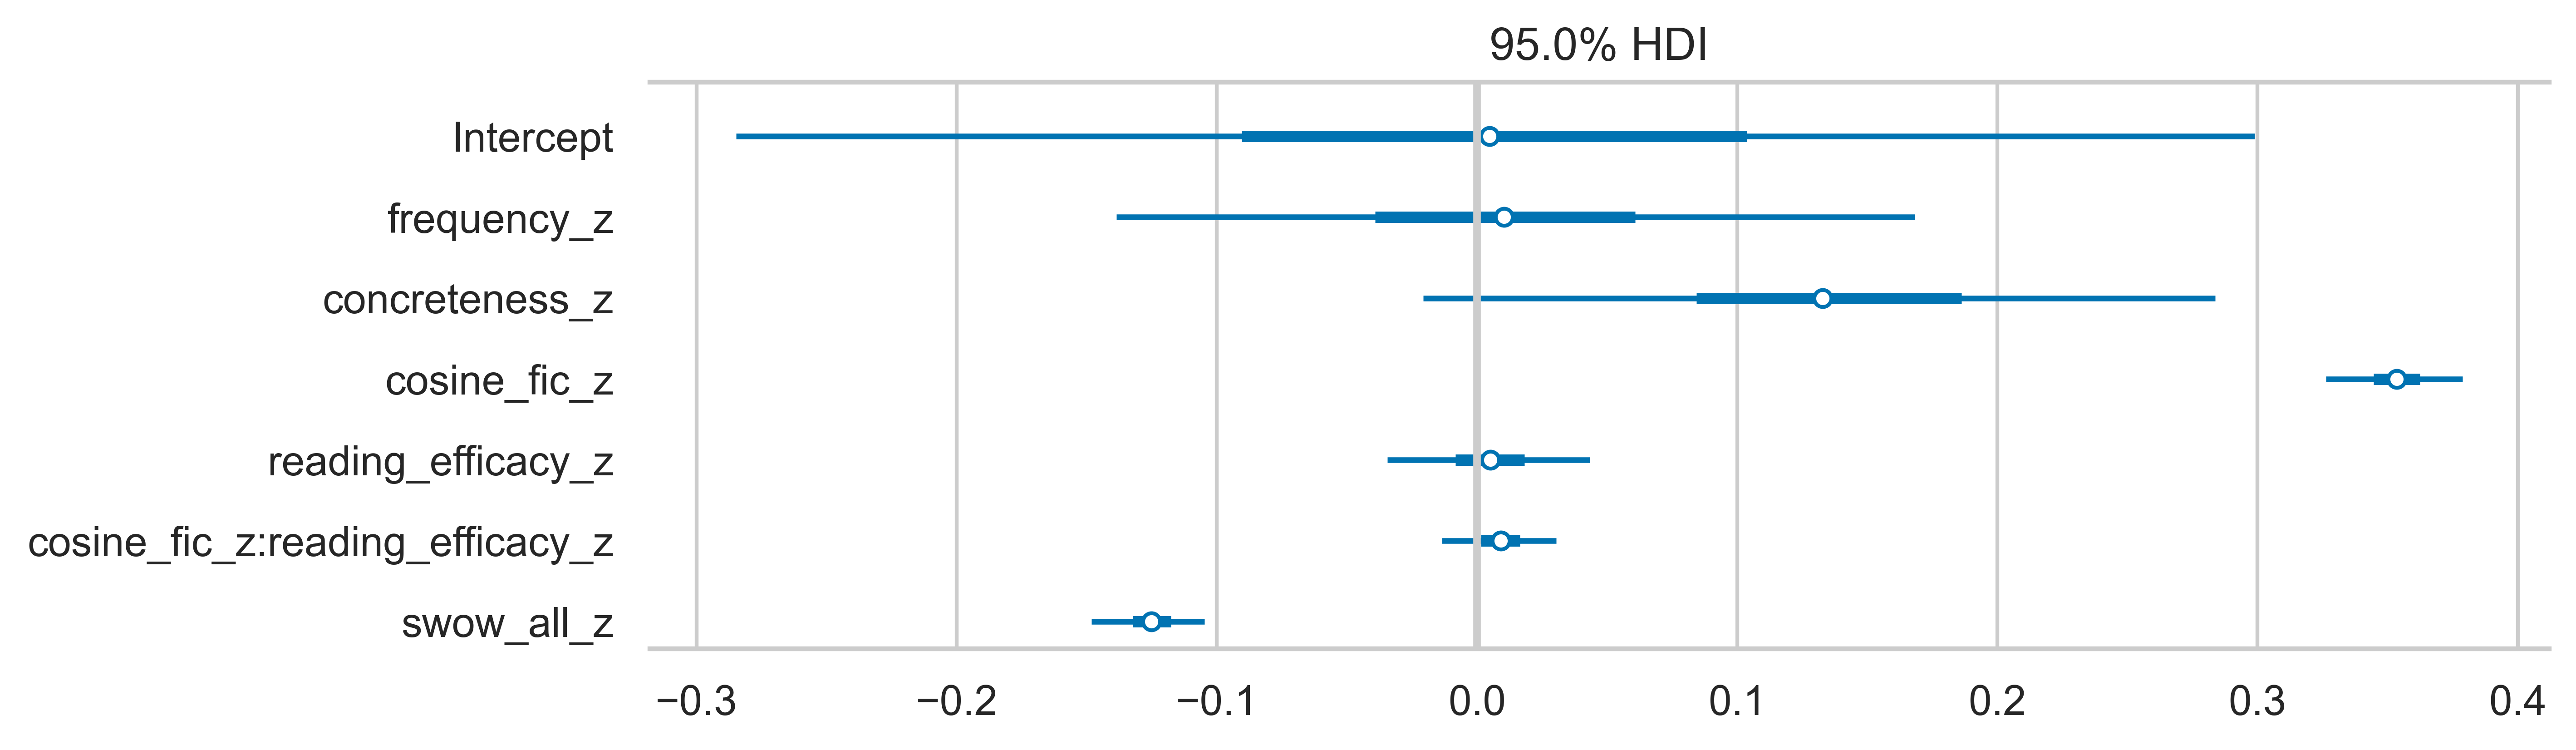

In [23]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_efficacy_z',
    'cosine_fic_z:reading_efficacy_z',
    'swow_all_z',
]
g = az.plot_forest(r_eff, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

### Reading for recognition

In [24]:
m_recog = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_recognition_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_recognition_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_recog = m_recog.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 40,877
[INFO] Finished [100%]: Average Loss = 40,877
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_recognition_z, cosine_fic_z:reading_recognition_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_recognition_z|pp_id_sigma, reading_recognition_z|pp_id_offset, cosine_fic_z:reading_recognition_z|pp_id_sigma, cosine_fic_z:reading_recognition_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|color_sigma, 1|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_recognition_z, cosine_fic_z:reading_recognition_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1456 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1456 seconds.


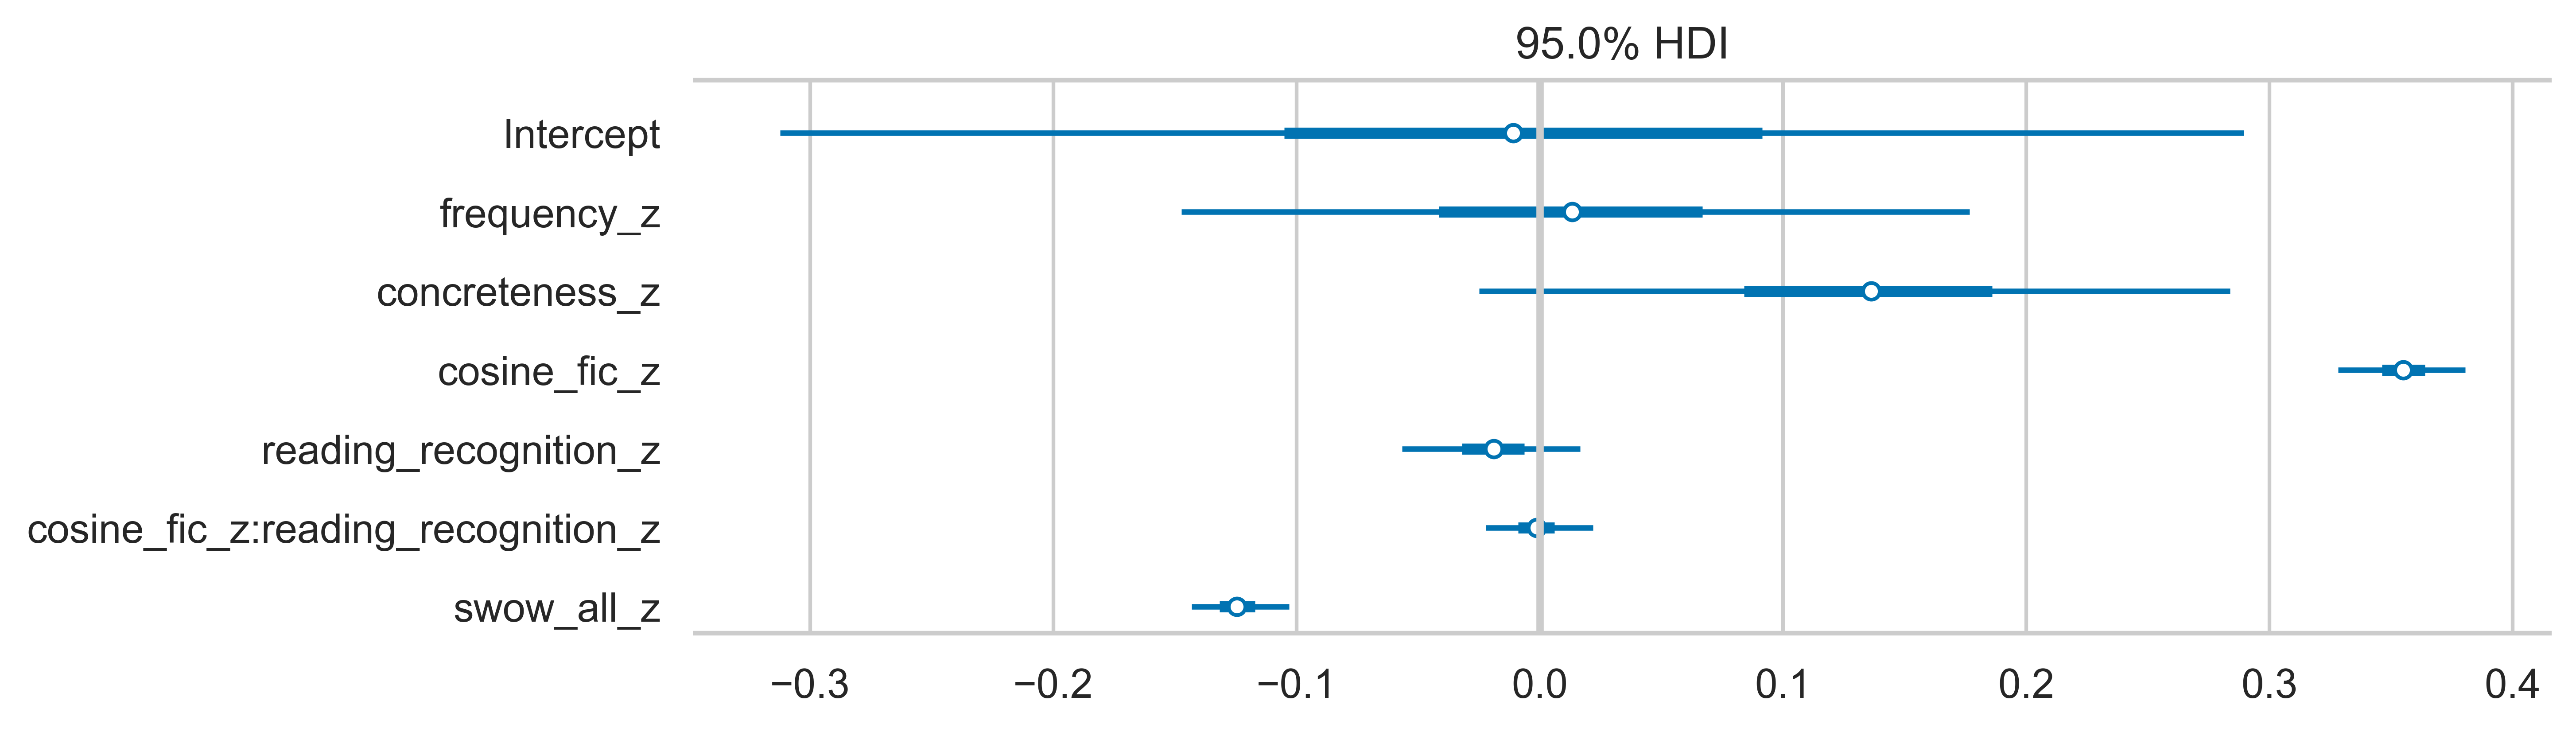

In [25]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_recognition_z',
    'cosine_fic_z:reading_recognition_z',
    'swow_all_z',
]
g = az.plot_forest(r_recog, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

### Reading to do well in other realms

In [26]:
m_realms = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_other_realms_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_other_realms_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_realms = m_realms.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 40,854
[INFO] Finished [100%]: Average Loss = 40,854
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_other_realms_z, cosine_fic_z:reading_other_realms_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_other_realms_z|pp_id_sigma, reading_other_realms_z|pp_id_offset, cosine_fic_z:reading_other_realms_z|pp_id_sigma, cosine_fic_z:reading_other_realms_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|color_sigma, 1|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_other_realms_z, cosine_fic_z:reading_other_realms_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1262 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1262 seconds.


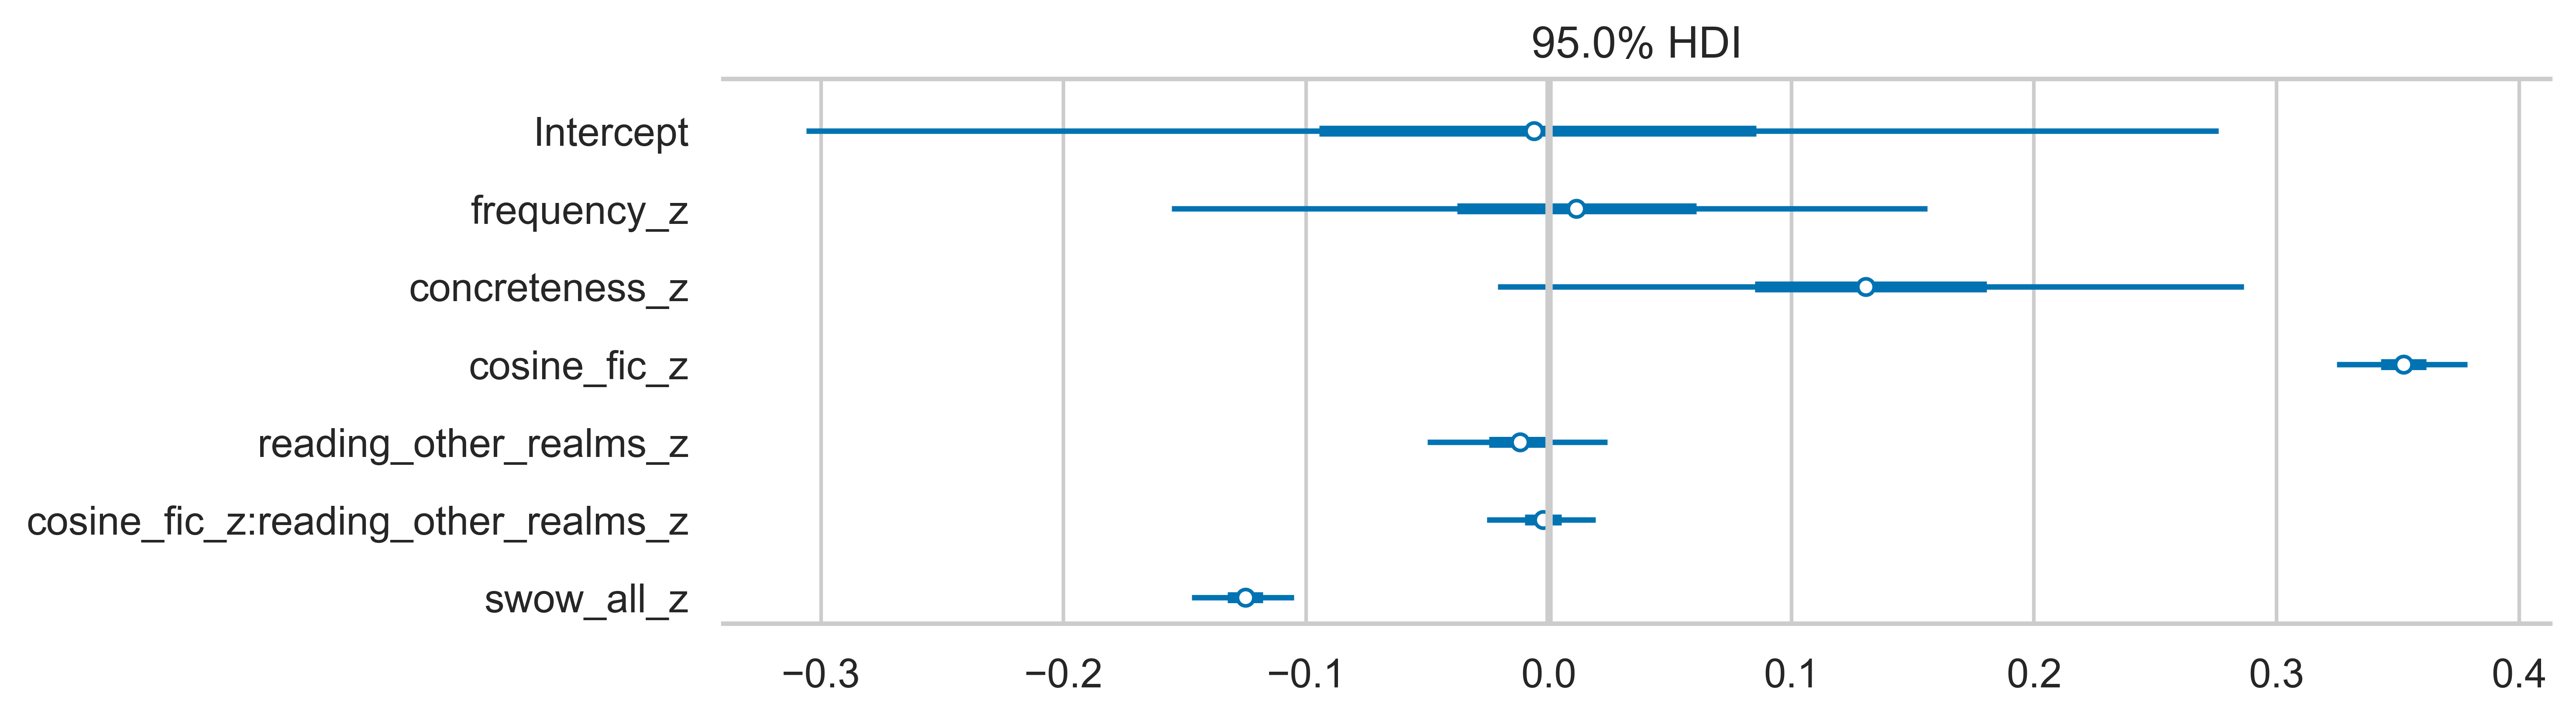

In [27]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_other_realms_z',
    'cosine_fic_z:reading_other_realms_z',
    'swow_all_z',
]
g = az.plot_forest(r_realms, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

None of the reading measures appear to have a meaningful effect on the ratings, nor do they interact with the semantic projection model trained on the COCA-fiction corpus.

There are (at least) two possible explanations for why these measures don't appear to have an effect:
1. Reading (and reading fiction specifically) does nothing to shape semantic knowledge (this seems unlikely, although for color associations simply experiencing the visual world certainly plays a big role as well).
2. Our participants are actually much more similar in fiction exposure than their scores suggest, because we are all exposed to a shared media environment (TV, Netflix, social media, etc.). Furthermore there is a baseline level of exposure to _written fiction_ that most undergraduate students can be expected to have (through completing K-12 education, etc.) which is sufficient for them to already be strongly semantically aligned. Further within-group differences in reading exposure then don't have much of an effect (i.e. there is some sort of ceiling effect happening).

## Self-ratings versus other-ratings

In [97]:
from scipy.stats import pearsonr
df_joint = df_joint.sort_values(['color', 'dimension'])

print('Correlation between self-ratings and other-ratings, raw data:')
print(pearsonr(
    df_joint.loc[
        (df_joint.self_vs_other == 'self') & (df_joint.experiment == 'replication_1'),
        'rating_z'
    ],
    df_joint.loc[
        (df_joint.self_vs_other == 'other') & (df_joint.experiment == 'replication_1'),
        'rating_z'
    ]
))
print()
df_agg = df_joint.groupby(['experiment', 'self_vs_other', 'color', 'dimension']).mean().reset_index()
print('Correlation between self-ratings and other-ratings, aggregated by color and dimension:')
print(pearsonr(
    df_agg.loc[
        (df_agg.self_vs_other == 'self') & (df_agg.experiment == 'replication_1'),
        'rating_z'
    ],
    df_agg.loc[
        (df_agg.self_vs_other == 'other') & (df_agg.experiment == 'replication_1'),
        'rating_z'
    ]
))

Correlation between self-ratings and other-ratings, raw data:
PearsonRResult(statistic=0.8162114409504398, pvalue=0.0)

Correlation between self-ratings and other-ratings, aggregated by color and dimension:
PearsonRResult(statistic=0.9852944630312472, pvalue=1.0715695247538623e-124)


Clearly, the relationship between self- and other-ratings is extremely strong, and while there is some variation between those ratings within each participant (i.e. .82 is not a perfect correlation) there are no systematic differences across participants (i.e. .99 is almost perfectly correlated, so it does not seem to be the case that e.g. all participants think that they personally rate "jealous" and "green" as more strongly related than other people do).

We can model the relationship between fiction embedding projections and self- and other-ratings separately, to see if participants' other-ratings are more strongly predicted by the projections. This seems unlikely given the strong correlations between the two ratings, but if participants have consistent hypotheses about others' associations, we might expect them to have gleaned those from language, and would therefore expect their other-ratings to be closer to the embedding projections that also come from language.

In [36]:
m_other = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + self_vs_other_z*cosine_fic_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + self_vs_other_z*cosine_fic_z + swow_all_z|pp_id)'
    + ' + (1 + self_vs_other_z|dimension)'
    + ' + (1 + self_vs_other_z|color)',
    df_joint[df_joint['experiment'] == 'replication_1']
)
r_other = m_other.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 14,767
[INFO] Finished [100%]: Average Loss = 14,767
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, self_vs_other_z, cosine_fic_z, self_vs_other_z:cosine_fic_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, self_vs_other_z|pp_id_sigma, self_vs_other_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, self_vs_other_z:cosine_fic_z|pp_id_sigma, self_vs_other_z:cosine_fic_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, self_vs_other_z|dimension_sigma, self_vs_other_z|dimension_offset, 1|color_sigma, 1|color_offset, self_vs_other_z|color_sigma, self_vs_other_z|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, self_vs_other_z, cosine_fic_z, self_vs_other_z:cosi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 478 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 478 seconds.


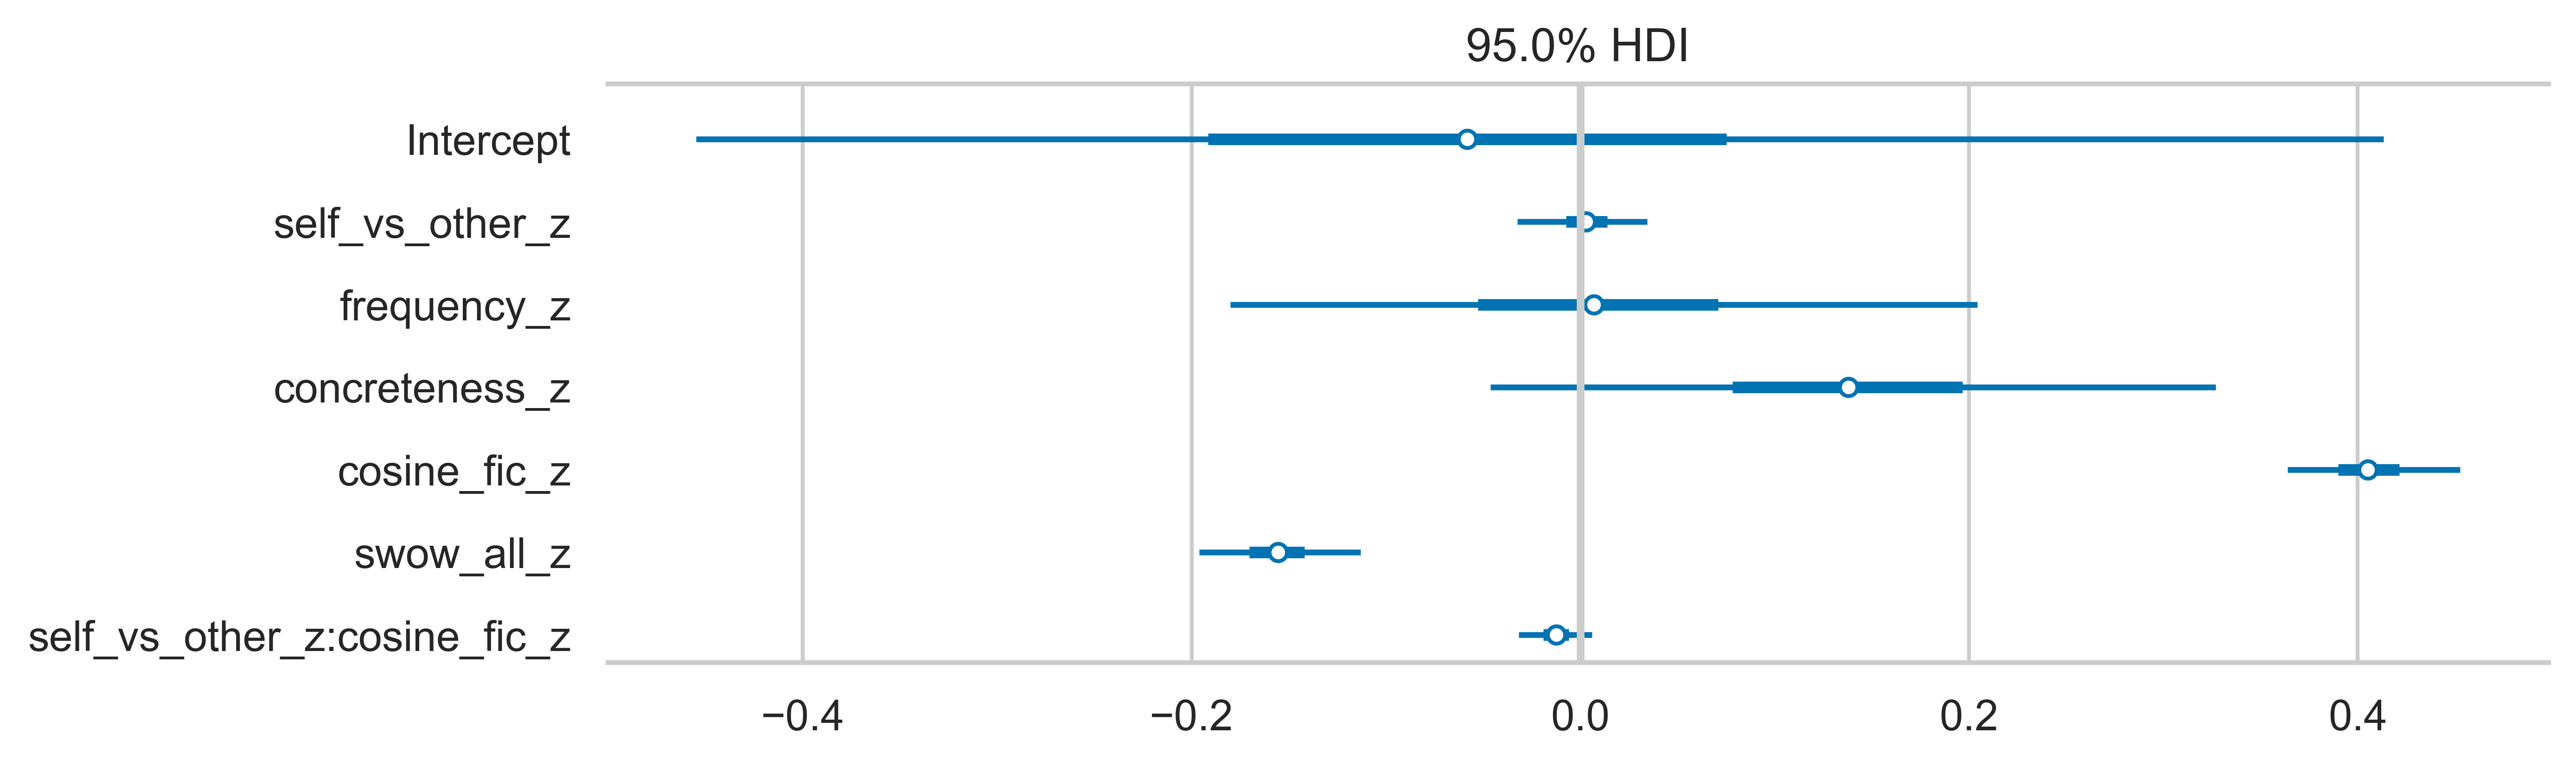

In [37]:
varnames = [
    'Intercept',
    'self_vs_other_z',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'swow_all_z',
    'self_vs_other_z:cosine_fic_z',
]
g = az.plot_forest(r_other, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

In [38]:
display(az.summary(r_other, var_names=varnames, hdi_prob=.95).round(2))

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.06,0.21,-0.46,0.41,0.01,0.01,741.0,1081.0,1.0
self_vs_other_z,0.00,0.02,-0.03,0.03,0.00,0.00,2223.0,2496.0,1.0
frequency_z,0.01,0.10,-0.18,0.20,0.00,0.00,1072.0,1760.0,1.0
concreteness_z,0.14,0.09,-0.05,0.33,0.00,0.00,989.0,1416.0,1.0
cosine_fic_z,0.40,0.02,0.36,0.45,0.00,0.00,3638.0,3205.0,1.0
swow_all_z,-0.16,0.02,-0.20,-0.11,0.00,0.00,1119.0,1931.0,1.0
self_vs_other_z:cosine_fic_z,-0.01,0.01,-0.03,0.01,0.00,0.00,5199.0,3054.0,1.0


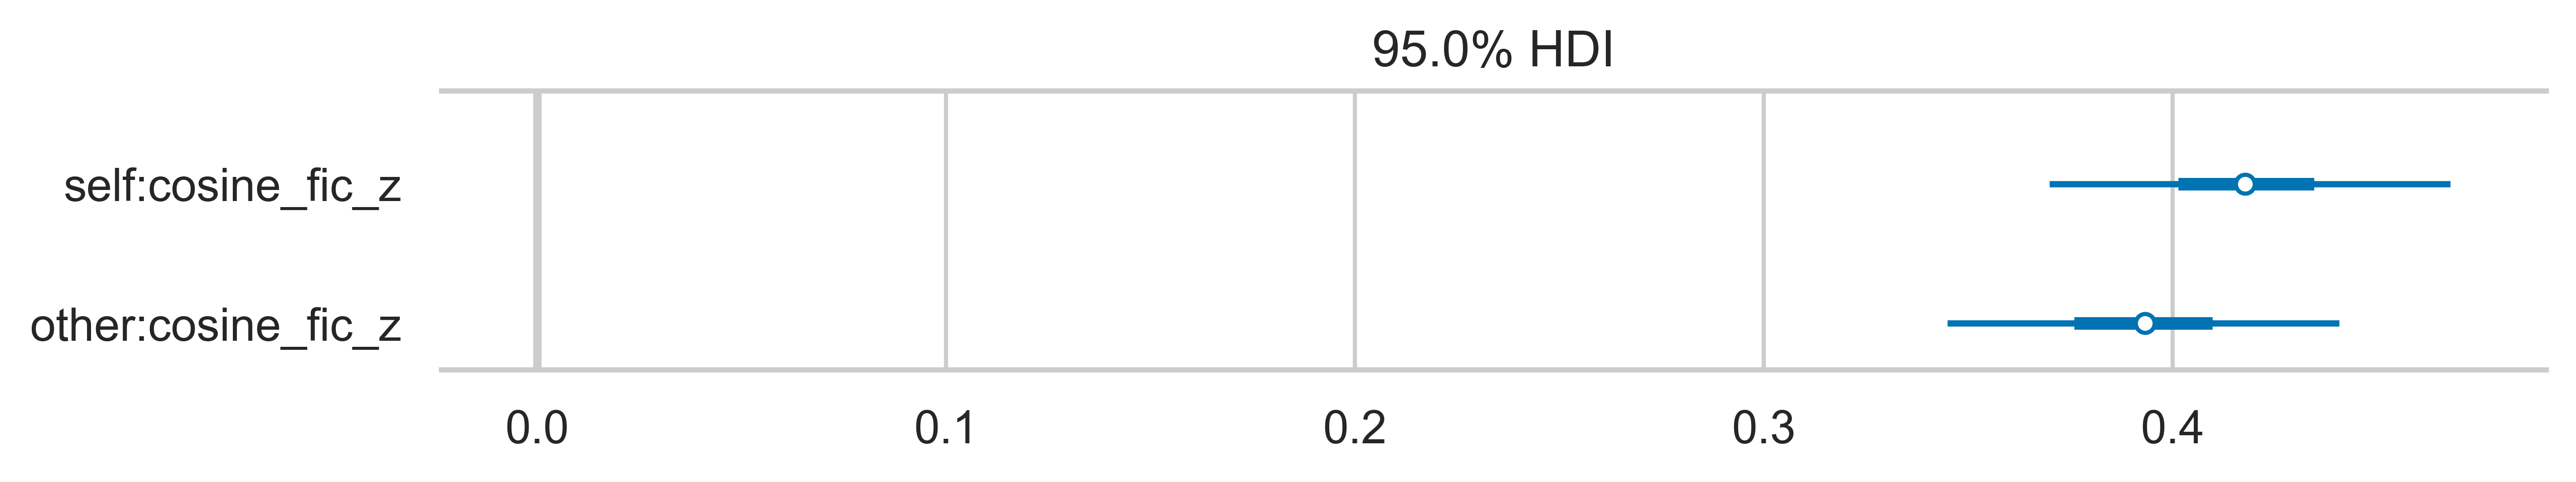

In [39]:
# compute and plot conditional effect of cosine in sighted and blind groups
from copy import deepcopy
trace = deepcopy(r_other.posterior)
# effect of cosine in blind group in orginal experiment
trace['self:cosine_fic_z'] = trace['cosine_fic_z'] - trace['self_vs_other_z:cosine_fic_z']
    # effect of cosine in sighted group across both experiments
trace['other:cosine_fic_z'] = trace['cosine_fic_z'] + trace['self_vs_other_z:cosine_fic_z']

varnames = ['self:cosine_fic_z', 'other:cosine_fic_z']
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00784313725490196, 0.6196078431372549, 0.45098039215686275)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8352941176470589, 0.3686274509803922, 0.0)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,group,predictor
0,self:cosine_fic_z,0.418,0.025,0.370,0.468,0.0,0.0,3756.0,3211.0,1.0,self,cosine_fic_z
1,other:cosine_fic_z,0.393,0.025,0.345,0.441,0.0,0.0,3813.0,3470.0,1.0,other,cosine_fic_z


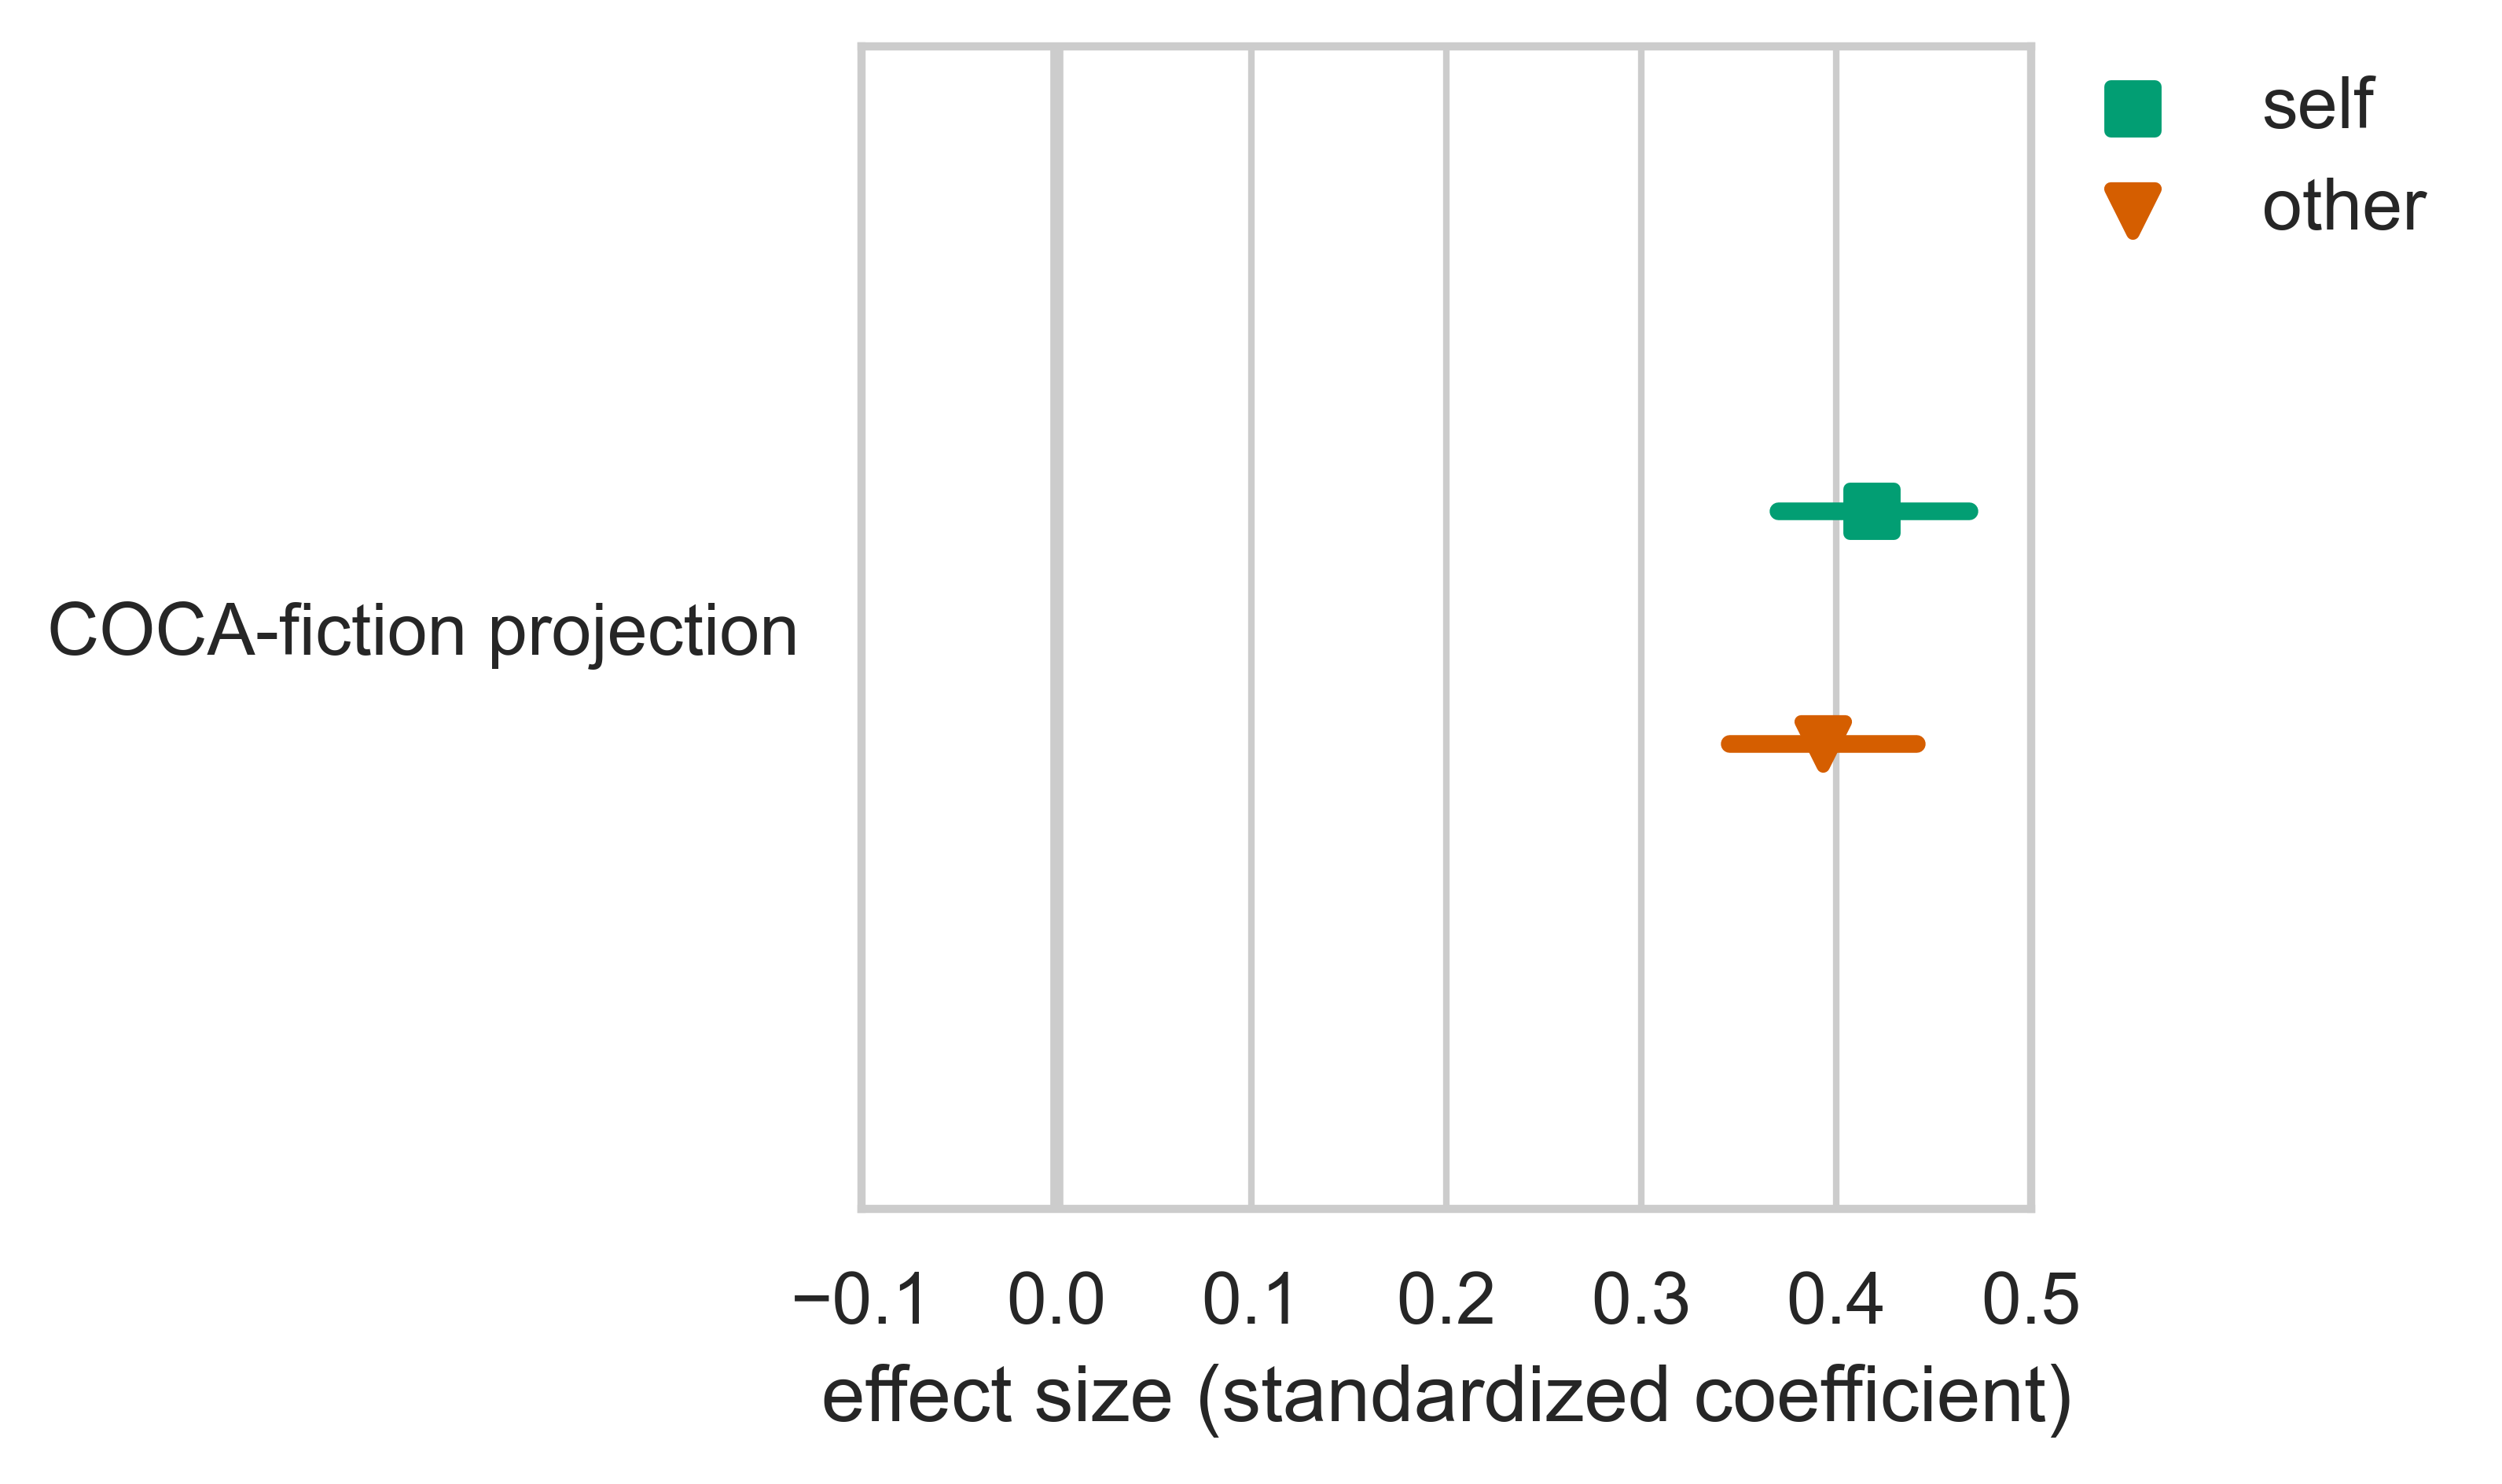

In [99]:
varnames = [
    'self:cosine_fic_z',
    'other:cosine_fic_z',
]
trace_df = az.summary(trace, hdi_prob=.95, var_names=varnames).reset_index()
sns.set(palette='colorblind', style='whitegrid')
trace_df['group'] = trace_df['index'].apply(lambda x: x.split(':')[0])
trace_df['predictor'] = trace_df['index'].apply(lambda x: x.split(':')[1])
g, ax = plt.subplots(figsize=[3.2, 3.2])
ax.axvline(0, color='.8', linewidth=2)
sns.pointplot(data=trace_df, hue='group', x='mean', y='predictor', markers=['s', 'v'],
              join=False, ax=ax,
              palette=sns.color_palette()[2:], dodge=.2)
hdi_df = trace_df.melt(id_vars=['predictor', 'group'], value_vars=['hdi_2.5%', 'hdi_97.5%'])
sns.pointplot(data=hdi_df, hue='group', markers='', x='value',
              y='predictor', ax=ax, join=False,
              palette=sns.color_palette()[2:], dodge=.2)
ax.set(xlim=[-.1, .5], xticks=[-.1, 0, .1, .2, .3, .4, .5],
       ylabel='', xlabel='effect size (standardized coefficient)',
      #title='95% CIs for embedding projections\nafter altering corpora',
       title=''
)
ax.set(yticklabels=[
    'COCA-fiction projection',
])
labels = ax.get_legend_handles_labels()
ax.legend(handles=labels[0][:2], labels=labels[1][:2],
          bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, frameon=False)
plt.savefig('figures/self_other_forest.pdf', bbox_inches='tight')
display(trace_df)

It appears that there is very little difference in effect size and that, if anything, the self-ratings are slightly better predicted by language-derived projections.

# Convert notebook to html

In [20]:
convert_notebook('supplementary_analyses')

[NbConvertApp] Converting notebook supplementary_analyses.ipynb to html
[NbConvertApp] Writing 3016677 bytes to supplementary_analyses.html


Jupyter notebook `supplementary_analyses` converted successfully.